# Experiment 27

Experimenting with alternative sampling methods for GASP like spiral sampling, fiber sampling, and random sampling.

In [1]:
import sys
sys.path.insert(0, '../../')  

import math
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.animation as animation

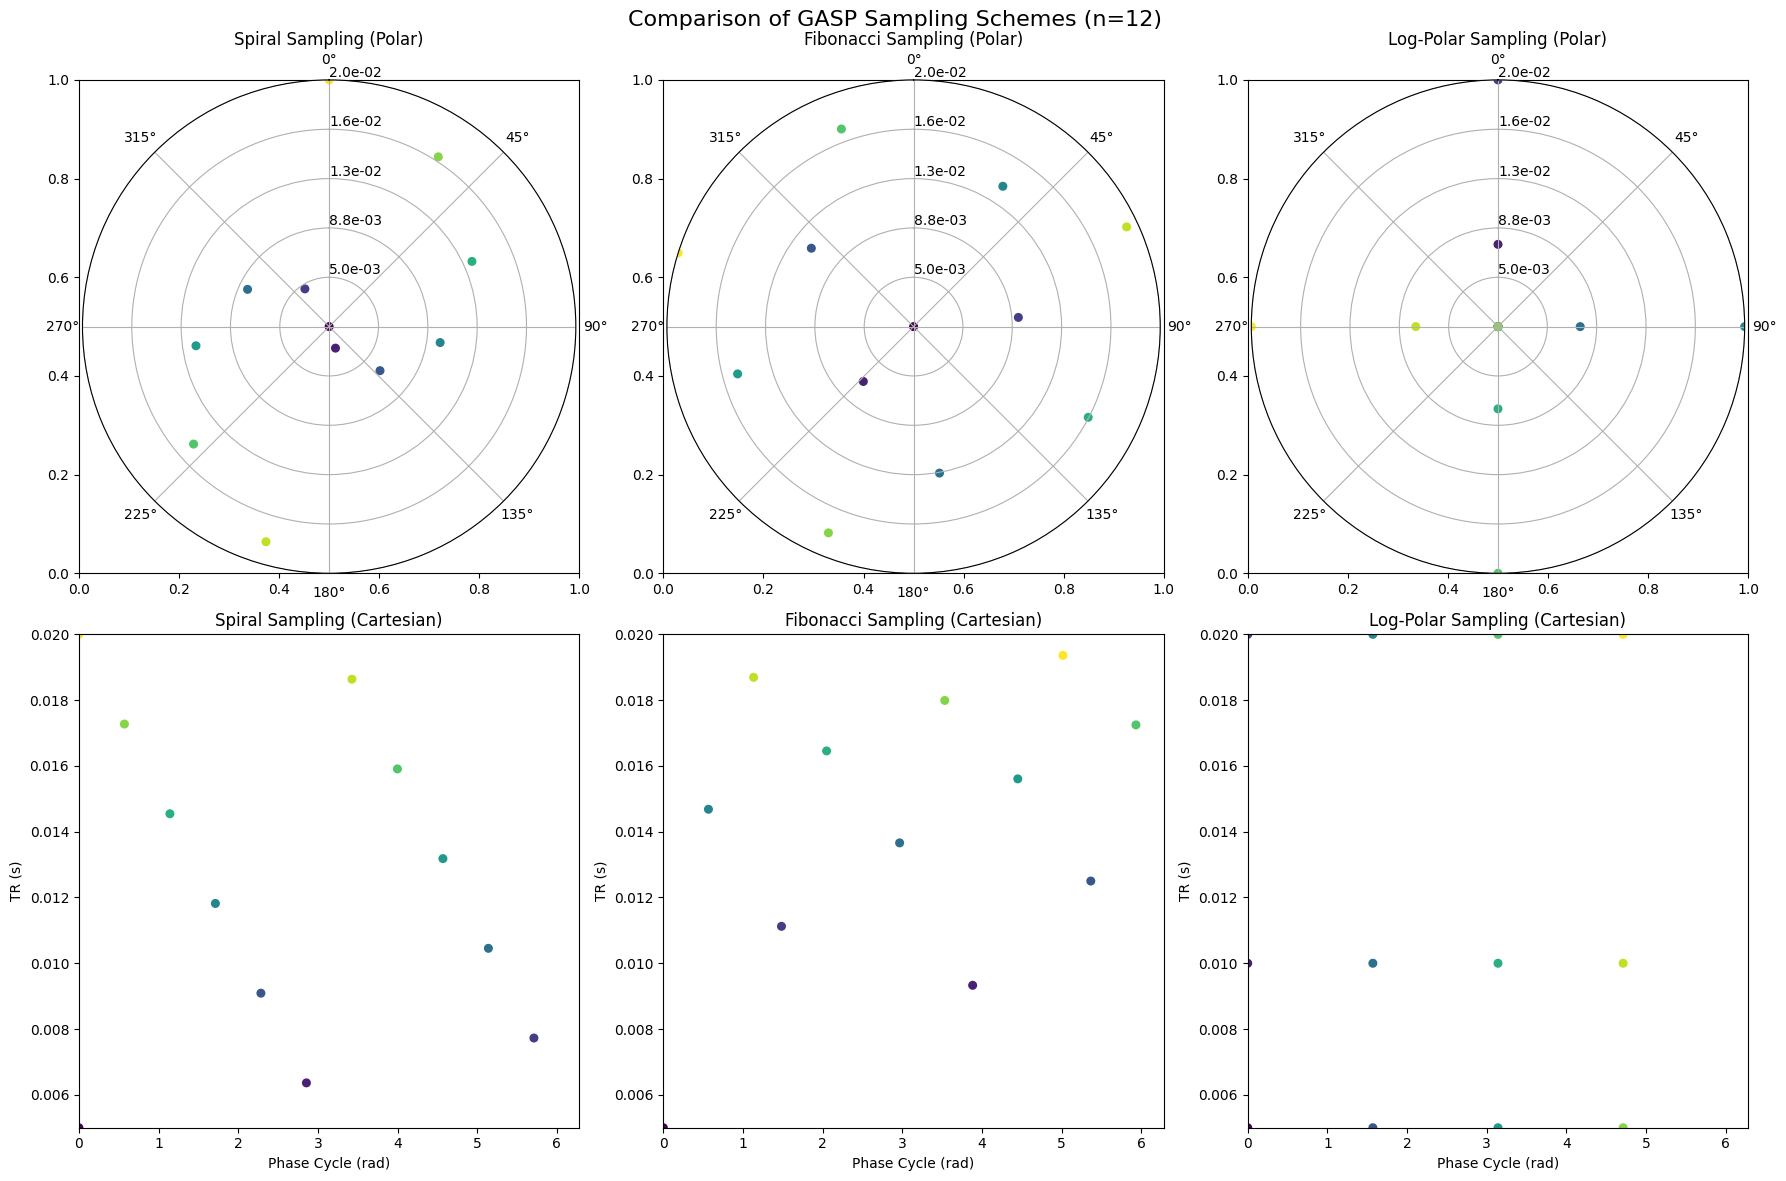

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def spiral_sampling(n_points, n_turns, tr_range=(5e-3, 20e-3)):
    theta = np.linspace(0, 2*np.pi*n_turns, n_points)
    r = np.linspace(0, 1, n_points)
    min_TR, max_TR = tr_range
    TR = min_TR + r * (max_TR - min_TR)
    PC = theta % (2*np.pi)
    return TR, PC

def fibonacci_sampling(n_points, tr_range=(5e-3, 20e-3)):
    golden_ratio = (1 + 5**0.5) / 2
    i = np.arange(n_points)
    theta = 2 * np.pi * i / golden_ratio
    r = np.sqrt(i / n_points)
    min_TR, max_TR = tr_range
    TR = min_TR + r * (max_TR - min_TR)
    PC = theta % (2*np.pi)
    return TR, PC

def log_polar_sampling(n_points, tr_range=(5e-3, 20e-3)):
    n_radial = int(np.sqrt(n_points))
    n_angular = n_points // n_radial
    
    min_TR, max_TR = tr_range
    log_min, log_max = np.log(min_TR), np.log(max_TR)
    r = np.exp(np.linspace(log_min, log_max, n_radial))
    theta = np.linspace(0, 2*np.pi, n_angular, endpoint=False)
    R, Theta = np.meshgrid(r, theta)
    TR, PC = R.flatten(), Theta.flatten()
    
    if len(TR) > n_points:
        TR, PC = TR[:n_points], PC[:n_points]
    elif len(TR) < n_points:
        extra = n_points - len(TR)
        TR = np.pad(TR, (0, extra), mode='edge')
        PC = np.pad(PC, (0, extra), mode='edge')
    
    return TR, PC

def compare_gasp_sampling_schemes(n_points=100, tr_range=(5e-3, 20e-3)):
    """
    Create a comparison plot of three GASP sampling schemes in both polar and Cartesian coordinates.
    
    Parameters:
    n_points (int): Number of points for sampling.
    tr_range (tuple): Range of TR values (min_TR, max_TR).
    """
    # Generate data for each sampling scheme
    TR_spiral, PC_spiral = spiral_sampling(n_points, 5, tr_range)
    TR_fib, PC_fib = fibonacci_sampling(n_points, tr_range)
    TR_logpolar, PC_logpolar = log_polar_sampling(n_points, tr_range)

    # Create the comparison plot
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"Comparison of GASP Sampling Schemes (n={n_points})", fontsize=16)

    sampling_data = [
        (TR_spiral, PC_spiral, "Spiral Sampling"),
        (TR_fib, PC_fib, "Fibonacci Sampling"),
        (TR_logpolar, PC_logpolar, "Log-Polar Sampling")
    ]

    for col, (TR, PC, title) in enumerate(sampling_data):
        # Normalize TR for plotting
        TR_norm = (TR - TR.min()) / (TR.max() - TR.min())
        
        # Polar plot
        ax_polar = fig.add_subplot(2, 3, col+1, projection='polar')
        scatter_polar = ax_polar.scatter(PC, TR_norm, c=range(len(TR)), cmap='viridis', s=30)
        
        # Customize the polar plot
        ax_polar.set_ylim(0, 1)
        ax_polar.set_yticks(np.arange(0.2, 1.2, 0.2))
        ax_polar.set_yticklabels([f'{t:.1e}' for t in np.linspace(tr_range[0], tr_range[1], 5)])
        ax_polar.set_rlabel_position(0)
        ax_polar.set_theta_zero_location("N")
        ax_polar.set_theta_direction(-1)
        ax_polar.set_title(f"{title} (Polar)")

        # Cartesian plot
        ax_cart = axs[1, col]
        scatter_cart = ax_cart.scatter(PC, TR, c=range(len(TR)), cmap='viridis', s=30)
        
        # Customize the Cartesian plot
        ax_cart.set_xlim(0, 2*np.pi)
        ax_cart.set_ylim(tr_range[0], tr_range[1])
        ax_cart.set_xlabel('Phase Cycle (rad)')
        ax_cart.set_ylabel('TR (s)')
        ax_cart.set_title(f"{title} (Cartesian)")

    # Add a colorbar
    #cbar = fig.colorbar(scatter_cart, ax=axs.ravel().tolist(), orientation='vertical', pad=0.02)
    #cbar.set_label('Sample Index', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

# Run the comparison
compare_gasp_sampling_schemes(n_points=12)

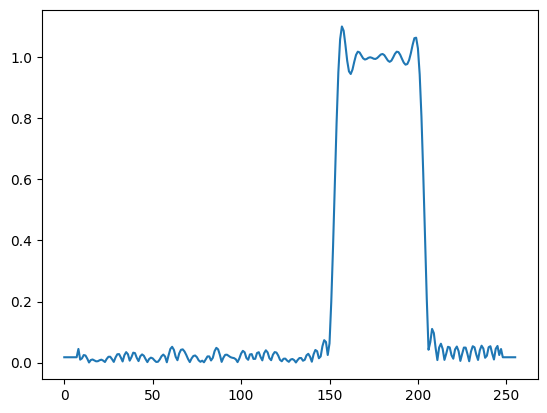

In [19]:
from gasp import process_data_for_gasp, train_gasp, simulate_ssfp_sampling, SSFPParams, responses

n_points = 48
tr_range = (5e-3, 20e-3)
TR_fib, PC_fib = fibonacci_sampling(n_points, tr_range)
params = SSFPParams(n_points, np.deg2rad(60), TR_fib, PC_fib)

M1 = simulate_ssfp_sampling(width=256, height=1, params=params, minTR = np.min(params.TRs), gradient = 2 * np.pi, phantom_type='line')
D1 = responses.square(width=256, bw=0.2, shift=0.2)
Ic1, An1 = train_gasp(M1, D1)

plt.plot(np.abs(Ic1).T)
plt.show()